# 334 Final Project: Predict X Challenge
# Name: Austin Hunt
# Professor: Dr. Anderson
# Date of Completion: April 28, 2018

### Step 1: Get the data

In [34]:
import pandas as pd
import numpy as np
import os 
import sklearn
# Data preparation
from sklearn.preprocessing import StandardScaler
# Plotting
import graphviz
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir('/Users/austinhunt/Downloads/')

df = pd.read_csv('expenses.csv')
 

### What does the data look like? 

In [35]:
print(df)
print()
## Checking the values

# Summarise number of entries
print('Number of records:',df.shape[0])
print('Number of columns:',df.shape[1])

# Unique values for each column
print('\nNumber of unique values for each column')
print(df.select_dtypes(exclude=['floating']).apply(lambda x: x.nunique(), axis=0))

# Which columns have nan values
print('\nDo columns have a null value?')
print(df.isnull().any())

# Count the number of rows that have any null values
print('\nHow many rows have any null values?')
print(df.isnull().any(axis=1).value_counts())

# Number of null values per column?
print('\nNumber of null values per column?')
df.apply(lambda x: x.isnull().value_counts())

       Unnamed: 0                            type  \
0               0   11 Move accompanying measures   
1               1   Stationary Postage & Printing   
2               2                    Meals-No GST   
3               3     06 Dinner - Drink (20% VAT)   
4               4       Parking/Tolls/Cong Charge   
5               5  Lunch when  at NON client site   
6               6                             NaN   
7               7  Lunch when  at NON client site   
8               8             Lunch (Max 22€) F/C   
9               9       Parking/Tolls/Cong Charge   
10             10                      Rental car   
11             11                        06 Lunch   
12             12                            Taxi   
13             13                     others 19 %   
14             14                         Parking   
15             15                Toll Fee (Local)   
16             16                            Rail   
17             17            Taxi - Travelled 

,Unnamed: 0,type,description,country,amount,amount_per_day,claim_type,is_food
False,70000.0,60645,53819,68880,70000.0,70000.0,70000.0,68647
True,NaN,9355,16181,1120,NaN,NaN,NaN,1353


 ### What are the classification labels?

In [36]:
label_names = df['is_food'].unique()
print(label_names)

['non-food' 'food' nan]


### Looks like there are some null values in the label column. Let's find out how many.

In [37]:
print(df['is_food'].isnull().sum())
print("That is ", (((df['is_food'].isnull().sum())/df['is_food'].count()).round(4))*100, " percent of the total row count" )

1353
That is  1.97  percent of the total row count


### In fact, let's do the same for all columns

In [38]:
max_percent_loss = 0
for column in df: 
    print(df[column].isnull().sum())
    max_percent_loss += (((df[column].isnull().sum())/df[column].count()).round(4))*100
    print((((df[column].isnull().sum())/df[column].count()).round(4))*100, " percent of the total row count for ", df[column].name ," is null" )
    print("\n\n")

print("The total # rows in the set: ", df.shape[0])

0
0.0  percent of the total row count for  Unnamed: 0  is null



9355
15.43  percent of the total row count for  type  is null



16181
30.07  percent of the total row count for  description  is null



1120
1.63  percent of the total row count for  country  is null



0
0.0  percent of the total row count for  amount  is null



0
0.0  percent of the total row count for  amount_per_day  is null



0
0.0  percent of the total row count for  claim_type  is null



1353
1.97  percent of the total row count for  is_food  is null



The total # rows in the set:  70000


### The significant values I see here are the percentages of the type and description columns being null. If we drop the null values from the data set, we can lose a MAXIMUM (assuming no overlap between the null values among the rows) of:

In [39]:
print(max_percent_loss," percent of the rows in the set, resulting in ", int((max_percent_loss/100)*len(df))," rows")

49.1  percent of the rows in the set, resulting in  34370  rows


### 50 percent of the data is pretty significant, but even if I drop null values, approximately 35,000 records (likely more than that since there's most likely overlap between the NaN rows) would still remain, which is still a large enough sample to make conclusive inferences/predictions from.


### Dropping those NaNs (and the unnamed primary key column)

In [40]:
orig_len = len(df)

# Removing the unnamed column
df = df.drop('Unnamed: 0',axis=1)


df = df.dropna()

### How did this affect my dataset? 

In [41]:
print("Dataset is now ", len(df), " rows long after dropping NaNs")
print("Lost", orig_len - len(df),"rows" )

Dataset is now  44524  rows long after dropping NaNs
Lost 25476 rows


### Took a bit of a hit, but now that the missing values are taken care of, we can get to work. 

### I'd like to start by grouping the "amount" values (by rounding them).

In [42]:
print("Initially, there are", df.amount.unique().size,"unique amount values")
df.amount = 10*round(df.amount/10)
print("After rounding, there are", df.amount.unique().size,"unique amount values")

Initially, there are 23380 unique amount values
After rounding, there are 208 unique amount values


### I can do the same with the amount_per_day column values.

In [43]:
print("Initially, there are", df.amount_per_day.unique().size,"unique amount values")
df.amount_per_day = 10*round(df.amount_per_day/10)
print("After rounding, there are", df.amount_per_day.unique().size,"unique amount values")

Initially, there are 25035 unique amount values
After rounding, there are 149 unique amount values


### Unique values in claim type? 

In [44]:
print(df['claim_type'].unique())

['Receipt']


### INTERESTING. After dropping the rows with NaN, there are NO "Per diem"s left in the claim_type column. THIS means that this is constant and thus will not serve as a useful predictor. 


### Now, I'd like to dig in to the string columns a bit. These will be a little more difficult. First, let's see how many unique types/descriptions there are. 

In [45]:
print("There are", df.type.unique().size,"unique types and", df.description.unique().size,"unique descriptions" )

There are 458 unique types and 26195 unique descriptions


### So, these are pretty high numbers. I have an idea, though. Let's start with type. 


### Maybe I could use one hot encoding to basically categorize the type based on the essential elements of the string. for ex:
### taxi        lunch          parking             rail             air            other          phone                 hotel        dinner          
###   0            1                    0                     0               0                  0                  0                          0               0
###   0            0                    0                     1               0                  0                  0                          0               0
###   0            0                    0                     0                 0                  0                  1                          0               0

### I believe that once I do THIS, then the description shouldn't be TOO necessary. I feel that the descriptions would offer redundant information, and thus including them would introduce unnecessary complexity

## Now, for the encoding. After doing a bit of scanning on the csv file, I found the following keywords to be the most common (and I believe they'll serve as useful predictors for the is_food classification). Here, I am creating columns for each type_keyword with all rows initialized to zeros.

In [46]:
df['taxi'] = np.zeros(len(df))
df['lunch'] = np.zeros(len(df))
df['parking'] = np.zeros(len(df))
df['rail'] = np.zeros(len(df))
df['air'] = np.zeros(len(df))
df['dinner'] = np.zeros(len(df))
df['other'] = np.zeros(len(df))
df['meals'] = np.zeros(len(df))
df['diesel'] = np.zeros(len(df))
df['gas'] = np.zeros(len(df))
df['breakfast'] = np.zeros(len(df))
df['phone'] = np.zeros(len(df))
df['health'] = np.zeros(len(df))
df['train'] = np.zeros(len(df))
df['stationery'] = np.zeros(len(df))
df['car'] = np.zeros(len(df))
df['rental'] = np.zeros(len(df))
df['entertainment'] = np.zeros(len(df))
df['lodging'] = np.zeros(len(df))
df['transportation'] = np.zeros(len(df))
df['laundry'] = np.zeros(len(df))
df['housing'] = np.zeros(len(df))
df['bus'] = np.zeros(len(df))
df['hotel'] = np.zeros(len(df))
df['bike'] = np.zeros(len(df))
df['motor'] = np.zeros(len(df))
df['toll'] = np.zeros(len(df))
df['medical'] = np.zeros(len(df))
df['personal'] = np.zeros(len(df))
df['underground'] = np.zeros(len(df))



### Now, I'll use parsing to gather indices to set specific rows of each type_keyword column to ONE (meaning this row has this keyword).

### Unfortunately, numpy does not define the 'in' operator as an element-wise boolean operation, so I can't just use np.where(substring in string). I need to take another approach. 

Note: I found this approach on Stack Overflow, posted by Chris Mueller, and I have modified it significantly to fit my objective

#### First, convert the type column to an array, then iterate over it with an if condition corresponding to the desired substring

In [47]:
# First, 
type_array = np.array(df.type)

taxi_indices = [i for i, type_string in enumerate(type_array) if 'taxi' in type_string.lower()]
lunch_indices = [i for i, type_string in enumerate(type_array) if 'lunch' in type_string.lower() or 'lnch' in type_string.lower()]
parking_indices = [i for i, type_string in enumerate(type_array) if 'parking' in type_string.lower()]
rail_indices = [i for i, type_string in enumerate(type_array) if 'rail' in type_string.lower()]
air_indices = [i for i, type_string in enumerate(type_array) if 'air' in type_string.lower()]
dinner_indices = [i for i, type_string in enumerate(type_array) if 'dinner' in type_string.lower()]
other_indices = [i for i, type_string in enumerate(type_array) if 'other' in type_string.lower() or 'sundry' in type_string.lower()]
meal_indices = [i for i, type_string in enumerate(type_array) if 'meal' in type_string.lower()]
diesel_indices = [i for i, type_string in enumerate(type_array) if 'diesel' in type_string.lower()]
gas_indices = [i for i, type_string in enumerate(type_array) if 'gas' in type_string.lower()]
breakfast_indices = [i for i, type_string in enumerate(type_array) if 'breakfast' in type_string.lower()]
phone_indices = [i for i, type_string in enumerate(type_array) if 'phone' in type_string.lower()]
health_indices = [i for i, type_string in enumerate(type_array) if 'health' in type_string.lower()]
train_indices = [i for i, type_string in enumerate(type_array) if 'train' in type_string.lower()]
stationery_indices = [i for i, type_string in enumerate(type_array) if 'stationery' in type_string.lower() or 'stationary' in type_string.lower()]
car_indices = [i for i, type_string in enumerate(type_array) if 'car' in type_string.lower()]
rental_indices = [i for i, type_string in enumerate(type_array) if 'rental' in type_string.lower()]
entertainment_indices = [i for i, type_string in enumerate(type_array) if 'entertainment' in type_string.lower()]
lodging_indices = [i for i, type_string in enumerate(type_array) if 'lodging' in type_string.lower()]
transportation_indices = [i for i, type_string in enumerate(type_array) if 'transport' in type_string.lower() or 'travel' in type_string.lower()]
laundry_indices = [i for i, type_string in enumerate(type_array) if 'laundry' in type_string.lower()]
housing_indices = [i for i, type_string in enumerate(type_array) if 'housing' in type_string.lower()]
bus_indices = [i for i, type_string in enumerate(type_array) if 'bus' in type_string.lower()]
hotel_indices = [i for i, type_string in enumerate(type_array) if 'hotel' in type_string.lower()]
toll_indices = [i for i, type_string in enumerate(type_array) if 'toll' in type_string.lower()]
bike_indices = [i for i, type_string in enumerate(type_array) if 'bike' in type_string.lower()]
motor_indices = [i for i, type_string in enumerate(type_array) if 'motor' in type_string.lower()]
medical_indices = [i for i, type_string in enumerate(type_array) if 'medical' in type_string.lower()]
personal_indices = [i for i, type_string in enumerate(type_array) if 'personal' in type_string.lower()]
underground_indices = [i for i, type_string in enumerate(type_array) if 'underground' in type_string.lower()]


### Now, here, it would definitely be nice to know how much of the data that these keywords actually cover. Hopefully, it covers a lot of the data. I think this ratio of coverage will be a decent indicator of utility for this encoding. 
### To find out what this coverage ratio is, let's first get the total number of indices and then divide by the total length of the dataframe

In [48]:
all_indices = []
all_indices.extend(
    taxi_indices+
    lunch_indices+
    parking_indices+
    rail_indices+
    air_indices+
    dinner_indices+
    other_indices+
    meal_indices+
    diesel_indices+
    gas_indices+
    breakfast_indices+
    phone_indices+
    health_indices+
    train_indices+
    stationery_indices+
    car_indices+
    rental_indices+
    entertainment_indices+
    toll_indices+
    bike_indices+
    lodging_indices+
    hotel_indices+
    transportation_indices+
    bus_indices+
    laundry_indices+
    housing_indices+
    motor_indices+
    medical_indices+
    personal_indices+
    underground_indices)
coverage_ratio = len(all_indices)/len(df)
print("The coverage ratio is", coverage_ratio)

The coverage ratio is 1.0698275087593208


## This covers the entire dataset (also contains overlap among the indices, which is why the ratio > 1). 

### So, now, I'll use these indices to fill in the respective columns with 1s.

In [49]:
df['taxi'].iloc[taxi_indices] = 1
df['lunch'].iloc[lunch_indices] = 1
df['parking'].iloc[parking_indices] = 1
df['rail'].iloc[rail_indices] = 1
df['air'].iloc[air_indices] = 1
df['dinner'].iloc[dinner_indices] = 1
df['other'].iloc[other_indices] = 1
df['meals'].iloc[meal_indices] = 1
df['diesel'].iloc[diesel_indices] = 1
df['gas'].iloc[gas_indices] = 1
df['breakfast'].iloc[breakfast_indices] = 1
df['phone'].iloc[phone_indices] = 1
df['health'].iloc[health_indices] = 1
df['train'].iloc[train_indices] = 1
df['stationery'].iloc[stationery_indices] = 1
df['car'].iloc[car_indices] = 1
df['rental'].iloc[rental_indices] = 1
df['entertainment'].iloc[entertainment_indices] = 1
df['toll'].iloc[toll_indices] = 1
df['bike'].iloc[bike_indices] = 1
df['lodging'].iloc[lodging_indices] = 1
df['hotel'].iloc[hotel_indices] = 1
df['transportation'].iloc[transportation_indices] = 1
df['bus'].iloc[bus_indices] = 1
df['laundry'].iloc[laundry_indices] = 1
df['housing'].iloc[housing_indices] = 1
df['motor'].iloc[motor_indices] = 1
df['medical'].iloc[medical_indices] = 1
df['personal'].iloc[personal_indices] = 1
df['underground'].iloc[underground_indices] = 1




/Users/austinhunt/miniconda3/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Data exploration

non-food    0.693289
food        0.306711
Name: is_food, dtype: float64

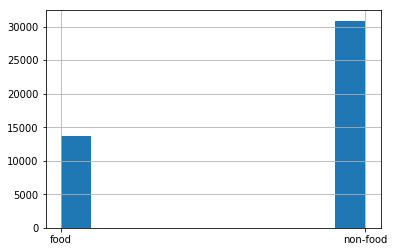

In [50]:
# Distribution of is_food
df['is_food'].hist()
df['is_food'].value_counts(normalize=True)



### Way more non-food values than food! Good to know. 

## Definitely should check for negative values in the amount/amount_per_day columns:

In [51]:
## Some of the entries have negative values for certain entries which seems strange, what is the count?

print('Number of negative values in amount:',df[df['amount']<0]['amount'].count())
print('Number of negative values in amount per day:',df[df['amount_per_day']<0]['amount_per_day'].count())

Number of negative values in amount: 8
Number of negative values in amount per day: 8


### How useful of a predictor is the country column?

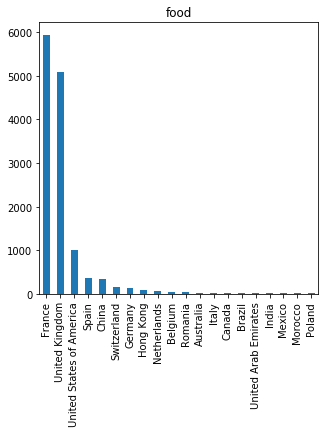

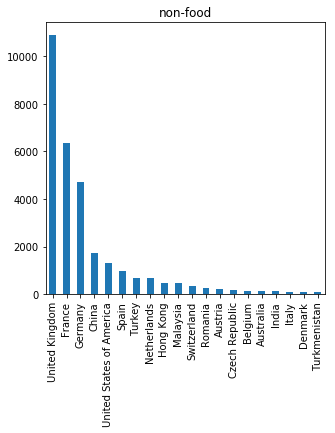

In [52]:
# Check the predictive power of 'country feature'
df.is_food = df.is_food.apply(lambda x: 1 if x == 'food' else 0)

df[df['is_food']==1]['country'].value_counts()[0:20].plot(kind='bar', figsize=(5,5),title='food')
plt.show()

df[df['is_food']==0]['country'].value_counts()[0:20].plot(kind='bar', figsize=(5,5),title='non-food')
plt.show()

### NOTE: It seems like the Country in which an expense is recorded would be independent of whether that expense is a food/non_food expense. However, after this analysis, there is definitely some dependence. It looks like using UK, France, Germany specifically as predictor variables (one-hot-encoding) could be very useful. 

In [53]:
## CREATE THE COLUMNS
df['USA'] = np.zeros(len(df))
df['France'] = np.zeros(len(df))
df['UK'] = np.zeros(len(df))
df['Germany'] = np.zeros(len(df))

# first convert column in question to an array
country_array = np.array(df.country)

#create arrays of indices for each country by finding rows that match the country name in the country array
USA_indices = [i for i, country_string in enumerate(country_array) if 'united states' in country_string.lower()
               or 'usa' in country_string.lower()
              or 'the united states' in country_string.lower()]
France_indices = [i for i, country_string in enumerate(country_array) if 'france' in country_string.lower()]
UK_indices = [i for i, country_string in enumerate(country_array) if 'uk' in country_string.lower()
             or 'united kingdom' in country_string.lower()]
Germany_indices = [i for i, country_string in enumerate(country_array) if 'germany' in country_string.lower()]

#fill in columns with respective indices
df['USA'].iloc[USA_indices] = 1
df['France'].iloc[France_indices] = 1
df['UK'].iloc[UK_indices] = 1
df['Germany'].iloc[Germany_indices] = 1


/Users/austinhunt/miniconda3/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### I think this is a good point to start considering a model. 
### We have a very large number of samples (even after removing the NaNs), and we're predicting the value of a categorical variable using labeled data, and we have less than 100,000 samples, so I'm going to try using the Linear Support Vector Classification model. I'm basing this decision on a very helpful diagram provided here:

https://stackoverflow.com/questions/2595176/which-machine-learning-classifier-to-choose-in-general


### Now, I want to RANDOMLY split the data into training and testing sets!

### Then split the training set into the predictors X and the response/target Y (multiple columns should be dropped from the predictors; type,description, country and claim_type namely, since these data have been either translated to alternative numeric forms or have been disregarded as non-useful variables.


### Do the same for the testing set. 

In [54]:
msk = np.random.rand(len(df)) < 0.8

trainingSet = df[msk]

testingSet = df[~msk]

print("The training set contains " ,len(trainingSet), "rows. (", len(trainingSet)/len(df)*100,"% of the original data )")
print()
print("The testing set contains " ,len(testingSet), "rows. (",len(testingSet)/len(df)*100,"% of the original data )")



The training set contains  35495 rows. ( 79.72104932171413 % of the original data )

The testing set contains  9029 rows. ( 20.278950678285867 % of the original data )


In [55]:
from sklearn.svm import LinearSVC

In [56]:
Y_train = trainingSet['is_food']

X_train = trainingSet[['amount','amount_per_day','taxi','lunch','parking',
                 'rail','air','dinner','other','meals','diesel','gas','breakfast',
                 'phone','health','train','stationery','car','rental','entertainment',
                 'lodging','transportation','laundry','housing','motor','bus','toll','bike',
                       'hotel','medical','personal','underground']]

Y_test = testingSet['is_food']

X_test = testingSet[['amount','amount_per_day','taxi','lunch','parking',
                 'rail','air','dinner','other','meals','diesel','gas','breakfast',
                 'phone','health','train','stationery','car','rental','entertainment',
                 'lodging','transportation','laundry','housing','motor','bus','toll',
                     'bike','hotel','medical','personal','underground']]




In [57]:
### Now, I can create the classifier and fit it to the training data set. 
classifier = LinearSVC(random_state=0)
classifier.fit(X_train,Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

### Now, I would like to determine the accuracy of this model by testing it on the test data (the model's "score" method does this)

In [58]:
LSVC_score = classifier.score(X_test,Y_test)
print("Classifier is", (LSVC_score.round(4))*100,"% accurate")

Classifier is 83.66 % accurate


### It seems to be ranging between 85 and 95% accurate, so what I'd like to do is let this fitting and scoring process iterate a few times and then get the average score to get a better idea of how appropriate this model is for this data. My hope is that the average leans more toward the higher end of the accuracy range I'm noticing. 

### Setting up a for loop that will iteratively: 
#### 1. split the dataframe into training and test subsets
#### 2. split each of those subsets into the necessary X and Y subsets
#### 3. Fit the model to the training data
#### 4. Calculate the accuracy of the model
#### 5. append the accuracy to accuracy list, which will be averaged at the end of the loop

In [59]:
##initialize a list, to be list of accuracies, then average the list at the end
accuracy_list = []
for i in range(0,5): 
    # 1. train/test split
    msk = np.random.rand(len(df)) < 0.8
    trainingSet = df[msk]
    testingSet = df[~msk]
    # 2. x/y split for each of the train and test subsets
    Y_train = trainingSet['is_food']

    X_train = trainingSet[['amount','amount_per_day','taxi','lunch','parking',
                     'rail','air','dinner','other','meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                           'bike','medical','USA','France','UK','Germany','personal','underground']]

    Y_test = testingSet['is_food']

    X_test = testingSet[['amount','amount_per_day','taxi','lunch','parking',
                     'rail','air','dinner','other','meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                         'bike','medical','USA','France','UK','Germany','personal','underground']]

    # 3. fit new model to training data
    classifier = LinearSVC(random_state=0)
    classifier.fit(X_train,Y_train)
    
    
    # 4. calculate accuracy 
    LSVC_score = classifier.score(X_test,Y_test)
    
    # 5. append this score to list 
    accuracy_list.append(LSVC_score)
    
avg_acc_lsvc_initial = sum(accuracy_list)/len(accuracy_list)

print("Average accuracy for Linear SVC model:",avg_acc_lsvc_initial)

Average accuracy for Linear SVC model: 0.91946092511


### I'm really interested to see how useful the non-type variables (amount, amount_per_day, claimTypeCode, and country) actually are. 

### From what I can tell just by scanning the csv file, it looks like amount and amount per day are significantly redundant, AND it doesn't seem like there is a correlation between either of them and the is_food value. Both high and low amounts are associated with is_food 


# So, I'm going to repeat the above code segment (the loop) but this time, I'm only going to include the one-hot-encoded columns for the original type column because I feel that this is the most significantly useful predictor.

In [60]:
##initialize a list, to be list of accuracies, then average the list at the end
accuracy_list = []
for i in range(0,5): 
    # 1. train/test split
    msk = np.random.rand(len(df)) < 0.8
    trainingSet = df[msk]
    testingSet = df[~msk]
    # 2. x/y split for each of the train and test subsets
    Y_train = trainingSet['is_food']

    X_train = trainingSet[['taxi','lunch','parking',
                     'rail','air','dinner','other','meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                     'bike','medical','personal','underground','USA','France','UK','Germany']]

    Y_test = testingSet['is_food']

    X_test = testingSet[['taxi','lunch','parking','rail','air','dinner','other',
                         'meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                     'bike','medical','personal','underground','USA','France','UK','Germany']]

    # 3. fit new model to training data
    classifier = LinearSVC(random_state=0)
    classifier.fit(X_train,Y_train)
    
    
    # 4. calculate accuracy 
    LSVC_score = classifier.score(X_test,Y_test)
    
    # 5. append this score to list 
    accuracy_list.append(LSVC_score)
    
avg_acc_lsvc_after1 = sum(accuracy_list)/len(accuracy_list)

print("Average accuracy for Linear SVC model (with ONLY type and Country):",avg_acc_lsvc_after1)

Average accuracy for Linear SVC model (with ONLY type and Country): 0.955019647201


In [61]:
##initialize a list, to be list of accuracies, then average the list at the end
accuracy_list = []
for i in range(0,5): 
    # 1. train/test split
    msk = np.random.rand(len(df)) < 0.8
    trainingSet = df[msk]
    testingSet = df[~msk]
    # 2. x/y split for each of the train and test subsets
    Y_train = trainingSet['is_food']

    X_train = trainingSet[['taxi','lunch','parking',
                     'rail','air','dinner','other','meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                     'bike','medical','personal','underground']]

    Y_test = testingSet['is_food']

    X_test = testingSet[['taxi','lunch','parking','rail','air','dinner','other',
                         'meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                     'bike','medical','personal','underground']]

    # 3. fit new model to training data
    classifier = LinearSVC(random_state=0)
    classifier.fit(X_train,Y_train)
    
    
    # 4. calculate accuracy 
    LSVC_score = classifier.score(X_test,Y_test)
    
    # 5. append this score to list 
    accuracy_list.append(LSVC_score)
    
avg_acc_lsvc_after2 = sum(accuracy_list)/len(accuracy_list)

print("Average accuracy for Linear SVC model (with ONLY TYPE):",avg_acc_lsvc_after2)

Average accuracy for Linear SVC model (with ONLY TYPE): 0.955571689339


# Displaying average accuracy differences between the two LSVC models (where the difference is the features considered)

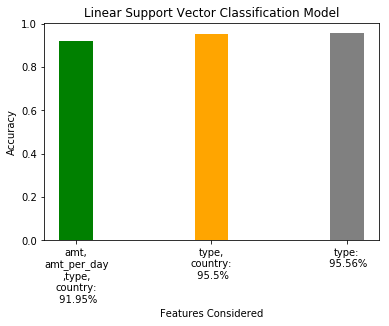

In [62]:
fig, ax = plt.subplots()
width = 0.5

ax.bar([1,3,5],[avg_acc_lsvc_initial,avg_acc_lsvc_after1,avg_acc_lsvc_after2], width,color=['green','orange','grey'])
ax.set_title("Linear Support Vector Classification Model")
ax.set_xlabel('Features Considered')
ax.set_ylabel('Accuracy')
ax.set_xticks([1,3,5])
label1 = "amt,\namt_per_day\n,type,\ncountry:\n " + str((avg_acc_lsvc_initial.round(4))*100) + "%"
label2 = "type,\ncountry:\n " + str((avg_acc_lsvc_after1.round(4))*100) + "%"
label3 = "type:\n " + str((avg_acc_lsvc_after2.round(4))*100) + "%"
ax.set_xticklabels([label1,label2,label3])
plt.show()



### it seems that exclusively using the type variable as a predictor leads to more accurate classifications, the model consistently tops out around 95% accuracy only using type, while topping out on average around 90% accuracy when using type, amount, amount_per_day

### Based on the diagram I'm referencing (link provided above), it seems that the k nearest neighbors model may be appropriate for the data in consideration (if we go ahead and say that the LSVC model "isn't working"), so I will now try this model (KNN) and perform the same sort of accuracy assessment.


In [63]:
from sklearn.neighbors import KNeighborsClassifier
##initialize a list, to be list of accuracies, then average the list at the end
accuracy_list = []
for i in range(0,5): 
    # 1. train/test split
    msk = np.random.rand(len(df)) < 0.8
    trainingSet = df[msk]
    testingSet = df[~msk]
    # 2. x/y split for each of the train and test subsets
    Y_train = trainingSet['is_food']

    X_train = trainingSet[['amount','amount_per_day','taxi','lunch','parking',
                     'rail','air','dinner','other','meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                     'bike','medical','personal','underground','USA','France','UK','Germany']]

    Y_test = testingSet['is_food']

    X_test = testingSet[['amount','amount_per_day','taxi','lunch','parking',
                     'rail','air','dinner','other','meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                     'bike','medical','personal','underground','USA','France','UK','Germany']]

    # 3. fit new model to training data
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train,Y_train)
    
    
    # 4. calculate accuracy 
    neigh_score = neigh.score(X_test,Y_test)
    
    # 5. append this score to list 
    accuracy_list.append(neigh_score)
    
avg_acc_knn_initial = sum(accuracy_list)/len(accuracy_list)

print("Average accuracy for KNN model AMT,AMT PER DAY, TYPE , COUNTRY:",avg_acc_knn_initial)

Average accuracy for KNN model AMT,AMT PER DAY, TYPE , COUNTRY: 0.967799030008


### This is interesting! It seems that the topping out point for accuracy of the LSVC model is the same accuracy value that KNN hovers around both with and without non-type variables. (without non-type variables is seen below for KNN)

In [64]:
accuracy_list = []
for i in range(0,5): 
    # 1. train/test split
    msk = np.random.rand(len(df)) < 0.8
    trainingSet = df[msk]
    testingSet = df[~msk]
    # 2. x/y split for each of the train and test subsets
    Y_train = trainingSet['is_food']

    X_train = trainingSet[['taxi','lunch','parking','rail','air','dinner','other',
                           'meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                    'bike','medical','personal','underground','USA','France','UK','Germany']]

    Y_test = testingSet['is_food']

    X_test = testingSet[['taxi','lunch','parking',  'rail','air','dinner','other',
                         'meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                    'bike','medical','personal','underground','USA','France','UK','Germany']]

    # 3. fit new model to training data
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train,Y_train)
    
    
    # 4. calculate accuracy 
    neigh_score = neigh.score(X_test,Y_test)
    
    # 5. append this score to list 
    accuracy_list.append(neigh_score)
    
avg_acc_knn_after1 = sum(accuracy_list)/len(accuracy_list)

print("Average accuracy for KNN model with ONLY TYPE AND COUNTRY:",avg_acc_knn_after1)

Average accuracy for KNN model with ONLY TYPE AND COUNTRY: 0.95380418013


In [65]:
accuracy_list = []
for i in range(0,5): 
    # 1. train/test split
    msk = np.random.rand(len(df)) < 0.8
    trainingSet = df[msk]
    testingSet = df[~msk]
    # 2. x/y split for each of the train and test subsets
    Y_train = trainingSet['is_food']

    X_train = trainingSet[['taxi','lunch','parking','rail','air','dinner','other',
                           'meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                    'bike','medical','personal','underground']]

    Y_test = testingSet['is_food']

    X_test = testingSet[['taxi','lunch','parking',  'rail','air','dinner','other',
                         'meals','diesel','gas','breakfast',
                     'phone','health','train','stationery','car','rental','entertainment',
                     'lodging','transportation','laundry','housing','motor','bus','toll',
                    'bike','medical','personal','underground']]

    # 3. fit new model to training data
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train,Y_train)
    
    
    # 4. calculate accuracy 
    neigh_score = neigh.score(X_test,Y_test)
    
    # 5. append this score to list 
    accuracy_list.append(neigh_score)
    
avg_acc_knn_after2 = sum(accuracy_list)/len(accuracy_list)

print("Average accuracy for KNN model with ONLY TYPE:",avg_acc_knn_after2)

Average accuracy for KNN model with ONLY TYPE: 0.95999961592


# Displaying average accuracy differences between the two KNN models (where the difference is the features considered)

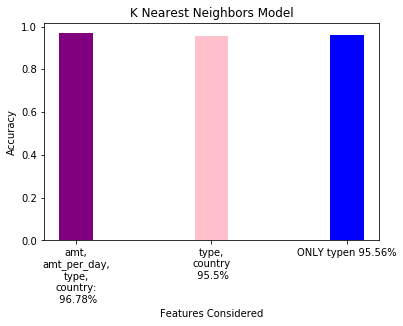

In [66]:
fig, ax = plt.subplots()
width = 0.5

ax.bar([1,3,5],[avg_acc_knn_initial,avg_acc_knn_after1,avg_acc_knn_after2], width,color=['purple','pink','blue'])
ax.set_title("K Nearest Neighbors Model")
ax.set_xlabel('Features Considered')
ax.set_ylabel('Accuracy')
ax.set_xticks([1,3,5])

label1 = "amt,\namt_per_day,\ntype,\ncountry:\n " + str((avg_acc_knn_initial.round(4))*100) + "%"
label2 = "type,\ncountry\n " + str((avg_acc_lsvc_after1.round(4))*100) + "%"
label3 = "ONLY typen " + str((avg_acc_lsvc_after2.round(4))*100) + "%"

ax.set_xticklabels([label1,label2,label3])
plt.show()



### It seems both KNN models (with non type vars and without non type vars) are both averaging about 96% accuracy. So naturally, if that's the case, it makes sense to use the SIMPLER model (less predictors) if both are equally accurate. 


## Required: "Create a subsection in your notebook that describes what new things you've added to the demo (10 points)."

### 1. I added the one-hot-encoding of the 'type' feature; I used string parsing to create new columns corresponding to the most common substrings of the type feature like meals, lunch, breakfast, dinner, taxi, etcetera. This allowed me really take advantage of the utility of the type feature as a predictor. 

### 2. I also used one-hot-encoding for the 'country' feature, but I only created a column for each of those countries with the greatest predictive values. 

### 3. I should note here that it doesn't seem like this one hot encoding of the country column really did much for either of the models' (KNN or LSVC) accuracy. This can be seen in comparing the second and third bars on each of the two graphs I provided.

### 4. I iteratively split the dataframe into training/testing subsets (I do this splitting randomly, so different scores are obtained each iteration), I fitted different models using those training subsets, and then I used the respective .score() method for those models (by passing in the test subset) to test how accurate the model was at predicting the target values after being fitted. 

### 5. I provided graphs displaying the differences in model accuracy based on the features that the models were considering. I provided a single graph for each of the two main models I used (KNN and Linear SVC). I chose these models because an explanation I was referencing (cited above) indicated these models would be the most appropriate for the data under consideration. 

### 6. The purpose of my iterative approach for each model was to gain more insight on how accurate the model actually was. I train and test each model 5 times and then average their scores (their accuracies) instead of just pulling the first score and then making some shallow comparison. 

### 7. Note: This code does take a little bit of time to execute because of the loops. 

# OVERALL: 
## The models I built seem to be very useful! Both KNN and LSVC seem to hover around 95% accuracy! 



